# InceptionResNetV2 Model Traning

## Importing Libraries and Setting Up Environments.

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content
%cp -av /content/drive/MyDrive/Final_year/Implementation/Machine_learning/Gingivititis_level_prediction/Dataset/Trainable_dataset Trainable_Dataset

/content
'/content/drive/MyDrive/Final_year/Implementation/Machine_learning/Gingivititis_level_prediction/Dataset/Trainable_dataset' -> 'Trainable_Dataset'
'/content/drive/MyDrive/Final_year/Implementation/Machine_learning/Gingivititis_level_prediction/Dataset/Trainable_dataset/validation' -> 'Trainable_Dataset/validation'
'/content/drive/MyDrive/Final_year/Implementation/Machine_learning/Gingivititis_level_prediction/Dataset/Trainable_dataset/validation/moderate' -> 'Trainable_Dataset/validation/moderate'
'/content/drive/MyDrive/Final_year/Implementation/Machine_learning/Gingivititis_level_prediction/Dataset/Trainable_dataset/validation/moderate/moderate (452).jpg' -> 'Trainable_Dataset/validation/moderate/moderate (452).jpg'
'/content/drive/MyDrive/Final_year/Implementation/Machine_learning/Gingivititis_level_prediction/Dataset/Trainable_dataset/validation/moderate/moderate (603).jpg' -> 'Trainable_Dataset/validation/moderate/moderate (603).jpg'
'/content/drive/MyDrive/Final_year/Imp

Set file paths

In [ ]:
train_path      = '/content/Trainable_Dataset/train'
test_path       = '/content/Trainable_Dataset/test'
validation_path = '/content/Trainable_Dataset/test'
Save_model_path = '/content/drive/MyDrive/Final_year/Implementation/Machine_learning/Gingivititis_level_prediction/Weight'

Import libraries

In [ ]:
import os
import cv2
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.image as mpimg

from glob import glob
from pathlib import Path
from matplotlib import pyplot as plt
from PIL import ImageFile, Image, ImageDraw

Import tensorflow and keras related libraries

In [ ]:
import tensorflow as tf

from keras import backend as K
from keras.preprocessing import image
from keras.layers import Layer, InputSpec
from keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

Import scikit-learn libraries for metrics and data preprocessing

In [ ]:
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.preprocessing import label_binarize
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

Other config

In [ ]:
# Display matplotlib plots inline
%matplotlib inline

# Check for truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Dataset visualization

View files count

In [ ]:
no_of_train_files = sum([len(files) for i, j, files in os.walk(train_path)])
print(f"No of train files : {no_of_train_files}")

No of train files : 1850


In [ ]:
no_of_train_files = sum([len(files) for i, j, files in os.walk(test_path)])
print(f"No of test files : {no_of_train_files}")

No of test files : 230


View folder content

In [ ]:
train_dir = Path(train_path)
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path(test_path)
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [ ]:
def path_to_image(filepath):
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = path_to_image(train_filepaths)
test_df = path_to_image(test_filepaths)

In [ ]:
train_df.head(100)

,Filepath,Label
0,/content/Trainable_Dataset/train/moderate/mode...,moderate
1,/content/Trainable_Dataset/train/healthy/healt...,healthy
2,/content/Trainable_Dataset/train/severe/severe...,severe
3,/content/Trainable_Dataset/train/moderate/mode...,moderate
4,/content/Trainable_Dataset/train/healthy/healt...,healthy
...,...,...
95,/content/Trainable_Dataset/train/severe/severe...,severe
96,/content/Trainable_Dataset/train/moderate/mode...,moderate
97,/content/Trainable_Dataset/train/healthy/healt...,healthy
98,/content/Trainable_Dataset/train/mild/mild (46...,mild


In [ ]:
test_df.head(100)

,Filepath,Label
0,/content/Trainable_Dataset/test/healthy/health...,healthy
1,/content/Trainable_Dataset/test/healthy/health...,healthy
2,/content/Trainable_Dataset/test/moderate/moder...,moderate
3,/content/Trainable_Dataset/test/moderate/moder...,moderate
4,/content/Trainable_Dataset/test/healthy/health...,healthy
...,...,...
95,/content/Trainable_Dataset/test/healthy/health...,healthy
96,/content/Trainable_Dataset/test/healthy/health...,healthy
97,/content/Trainable_Dataset/test/mild/mild (703...,mild
98,/content/Trainable_Dataset/test/healthy/health...,healthy


Display some pictures of the dataset

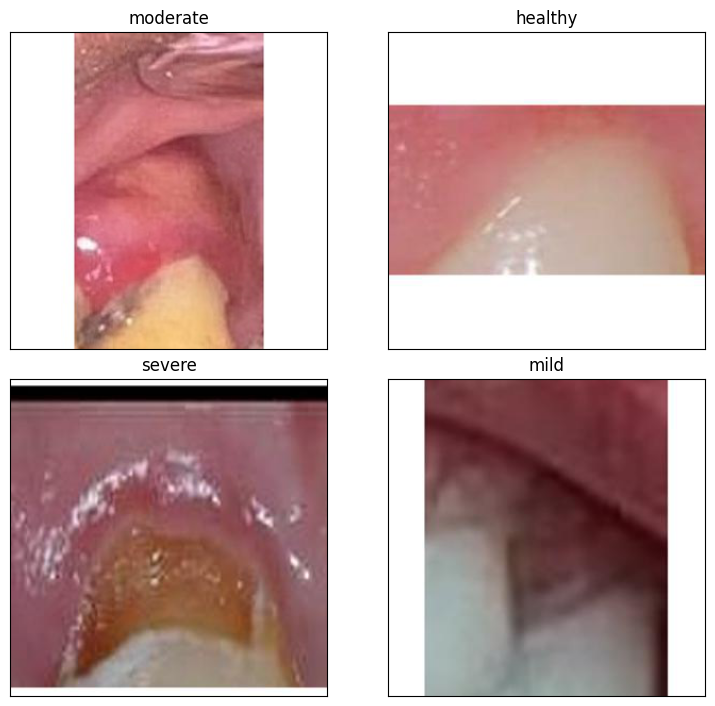

In [ ]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

## Dataset preparation

Create Categorie list

In [ ]:
category = os.listdir(train_path)
category
print(f"Categories : {category}")

Categories : ['healthy', 'moderate', 'severe', 'mild']


Define data generator

In [ ]:
data_gen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 360, 
                                   height_shift_range = 0.1, 
                                   shear_range = 0.1, 
                                   zoom_range = 0.1,
                                   fill_mode='nearest',
                                   brightness_range = [0.9, 1.2],
                                   vertical_flip=True,
                                   horizontal_flip = True,
                                   validation_split=0.2
                                  )

Create batches

In [ ]:
IMG_SIZE = 299
BATCH_SIZE = 16

In [ ]:
print("\nTrain Batches: ")
train_generator = data_gen.flow_from_directory(
                                            directory=train_path,
                                            target_size=(IMG_SIZE,IMG_SIZE),
                                            batch_size=BATCH_SIZE,
                                            color_mode="rgb",
                                            class_mode="categorical",
                                            shuffle=True,
                                            subset='training')

print("\nValidation Batches: ")
valid_generator = data_gen.flow_from_directory(
                                            directory=train_path,
                                            target_size=(IMG_SIZE,IMG_SIZE),
                                            batch_size=BATCH_SIZE,
                                            color_mode="rgb",
                                            class_mode="categorical",
                                            shuffle=True,
                                            subset='validation')


Train Batches: 
Found 1482 images belonging to 4 classes.

Validation Batches: 
Found 368 images belonging to 4 classes.


## Model preparation

Download model

In [ ]:
irv2 = tf.keras.applications.InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",)

225209952/225209952 [==============================] - 1s 0us/step


CNN Layer modifications

In [ ]:
conv = irv2.layers[-20].output
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
output = Flatten()(conv)
output = Dense(len(category), activation='softmax')(output)
conv_model = Model(inputs=irv2.input, outputs=output)

Model traning config

In [ ]:
opt1=tf.keras.optimizers.Adam(
    learning_rate=0.01,
    epsilon=0.1)

conv_model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

Summary

In [ ]:
conv_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Training InceptionResNetV2 model using Keras

In [ ]:
start = time.time()

history = conv_model.fit(
                    train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=100,
                    verbose=1)

print()
print('===================================================================================================================')
print("Total time: ", time.time() - start, "seconds")

Epoch 1/100
92/92 [==============================] - 194s 832ms/step - loss: 1.3461 - accuracy: 0.3383 - val_loss: 1.3388 - val_accuracy: 0.3696
Epoch 2/100
92/92 [==============================] - 70s 754ms/step - loss: 1.3095 - accuracy: 0.3820 - val_loss: 1.3813 - val_accuracy: 0.3723
Epoch 3/100
92/92 [==============================] - 70s 760ms/step - loss: 1.2087 - accuracy: 0.4516 - val_loss: 1.2450 - val_accuracy: 0.4674
Epoch 4/100
92/92 [==============================] - 69s 748ms/step - loss: 1.0409 - accuracy: 0.5389 - val_loss: 1.6037 - val_accuracy: 0.4728
Epoch 5/100
92/92 [==============================] - 78s 850ms/step - loss: 0.9700 - accuracy: 0.5839 - val_loss: 1.1727 - val_accuracy: 0.4457
Epoch 6/100
92/92 [==============================] - 68s 735ms/step - loss: 0.8889 - accuracy: 0.6228 - val_loss: 1.2654 - val_accuracy: 0.4864
Epoch 7/100
92/92 [==============================] - 67s 723ms/step - loss: 0.8520 - accuracy: 0.6323 - val_loss: 1.1316 - val_accuracy

## Plotting Accuracy of Gingivititis Classification Model

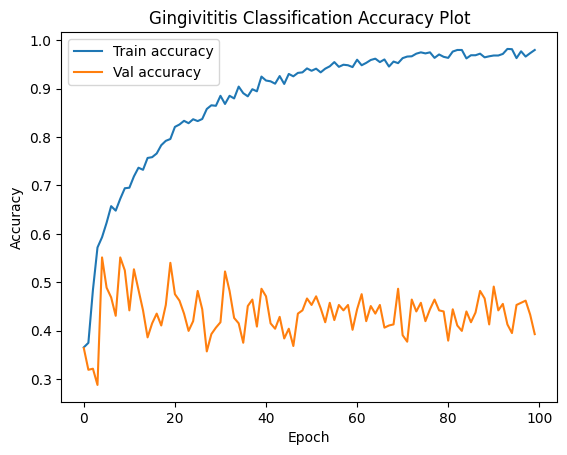

In [ ]:
plt.title('Gingivititis Classification Accuracy Plot')
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy','Val accuracy'], loc='best')
plt.show()

## Gingivititis Classification Loss Plot

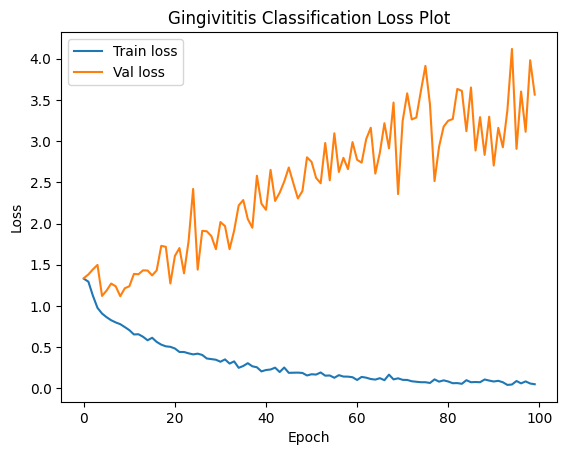

In [ ]:
plt.title('Gingivititis Classification Loss Plot')
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss','Val loss'], loc='best')
plt.show()

## Classification Report

In [ ]:
print("Validation Batches")
vali_datagen = ImageDataGenerator( rescale = 1.0/255.)
vali_batches = vali_datagen.flow_from_directory(validation_path,
                                           target_size=(IMG_SIZE,IMG_SIZE),
                                           batch_size=BATCH_SIZE,
                                           color_mode="rgb",
                                           class_mode="categorical",
                                           shuffle=False)

Validation Batches
Found 230 images belonging to 4 classes.


In [ ]:
predictions = conv_model.predict(vali_batches,verbose=0)

y_pred = np.argmax(predictions, axis=1)
y_true = vali_batches.classes
y_prob = predictions
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=category)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     healthy       0.94      0.95      0.95        85
      severe       0.83      0.81      0.82        43
    moderate       0.88      0.85      0.87        68
        mild       0.86      0.91      0.89        34

    accuracy                           0.89       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.89      0.89      0.89       230



## Hyperparameter optimization

In [ ]:
IMG_SIZE = 299
BATCH_SIZE = 16
EPOCHS = 100

In [ ]:
data_gen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 360, 
                                   height_shift_range = 0.1, 
                                   shear_range = 0.1, 
                                   zoom_range = 0.1,
                                   fill_mode='nearest',
                                   brightness_range = [0.9, 1.2],
                                   vertical_flip=True,
                                   horizontal_flip = True,
                                   validation_split=0.2
                                  )

In [ ]:
print("\nTrain Batches: ")
train_generator = data_gen.flow_from_directory(
                                            directory=train_path,
                                            target_size=(IMG_SIZE,IMG_SIZE),
                                            batch_size=BATCH_SIZE,
                                            color_mode="rgb",
                                            class_mode="categorical",
                                            shuffle=True,
                                            subset='training')

print("\nValidation Batches: ")
valid_generator = data_gen.flow_from_directory(
                                            directory=train_path,
                                            target_size=(IMG_SIZE,IMG_SIZE),
                                            batch_size=BATCH_SIZE,
                                            color_mode="rgb",
                                            class_mode="categorical",
                                            shuffle=True,
                                            subset='validation')


Train Batches: 
Found 1665 images belonging to 4 classes.

Validation Batches: 
Found 415 images belonging to 4 classes.


In [ ]:
start = time.time()

# history = conv_model.fit(
#                     train_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=valid_generator,
#                     validation_steps=STEP_SIZE_VALID,
#                     epochs=EPOCHS,
#                     verbose=1)

print()
print('===================================================================================================================')
print("Total time: ", time.time() - start, "seconds")


Total time:  0.00020241737365722656 seconds


In [ ]:
predictions = conv_model.predict(vali_batches,verbose=0)

y_pred = np.argmax(predictions, axis=1)
y_true = vali_batches.classes
y_prob=predictions
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=category)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     healthy       0.94      0.95      0.95        85
      severe       0.83      0.81      0.82        43
    moderate       0.88      0.85      0.87        68
        mild       0.86      0.91      0.89        34

    accuracy                           0.89       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.89      0.89      0.89       230



## Confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(category))
    plt.xticks(tick_marks, category, rotation=45)
    plt.yticks(tick_marks, category)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization

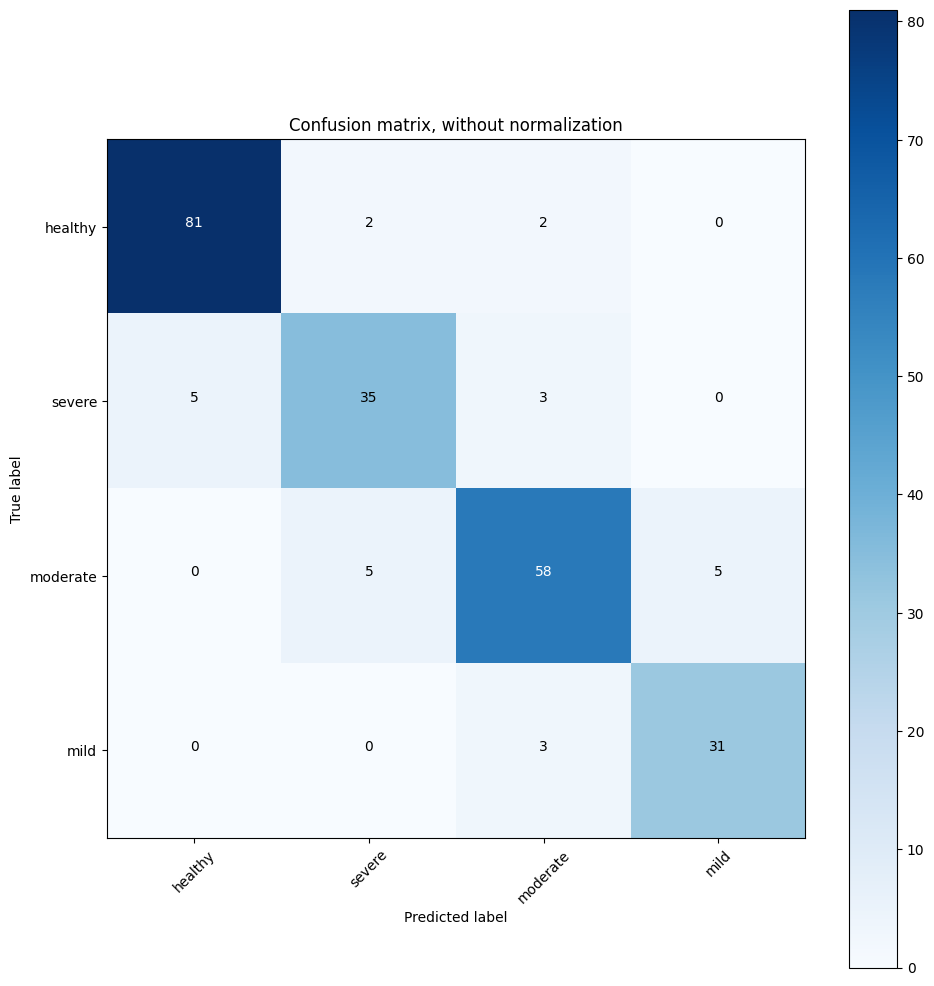

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=category, title='Confusion matrix, without normalization')
display()

Normalized confusion matrix

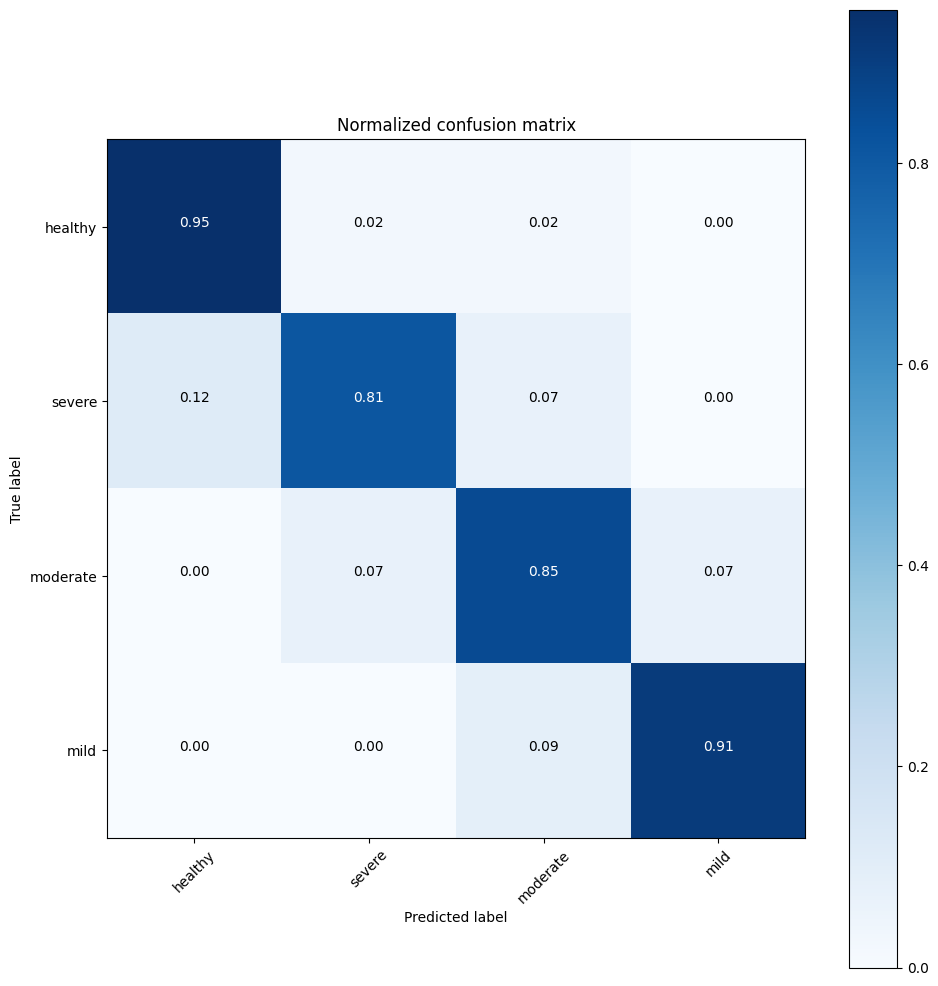

In [ ]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=category, normalize=True, title='Normalized confusion matrix')
display()

## Receiver operating characteristic - ROC curve

In [ ]:
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

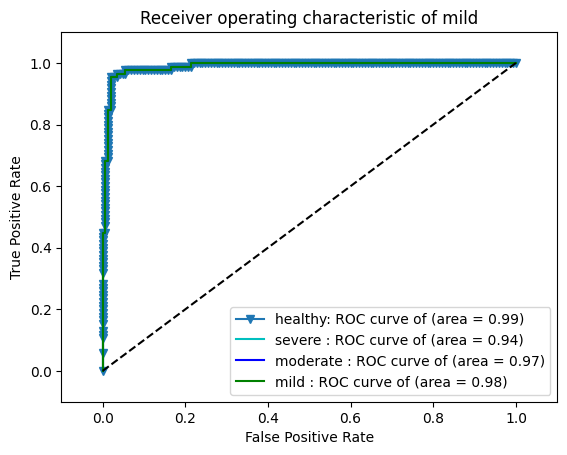

In [ ]:
plt.plot(fpr[0], tpr[0],'v-',label=f'{category[0]}: ROC curve of (area = {"{:.2f}".format(roc_auc[0])})')
plt.plot(fpr[0], tpr[0],'c',label=f'{category[1]} : ROC curve of (area = {"{:.2f}".format(roc_auc[1])})')
plt.plot(fpr[0], tpr[0],'b',label=f'{category[2]} : ROC curve of (area = {"{:.2f}".format(roc_auc[2])})')
plt.plot(fpr[0], tpr[0],'g',label=f'{category[3]} : ROC curve of (area = {"{:.2f}".format(roc_auc[3])})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%category[i])
plt.legend(loc="lower right")
plt.show()

## 2D Tsne Visualization

In [ ]:
tsne = TSNE(n_components=2, perplexity=10, learning_rate=100, angle=0.2, verbose=2)
transform = tsne.fit_transform(predictions)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 230 samples in 0.001s...
[t-SNE] Computed neighbors for 230 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 230 / 230
[t-SNE] Mean sigma: 0.000001
[t-SNE] Computed conditional probabilities in 0.021s
[t-SNE] Iteration 50: error = 59.6280212, gradient norm = 0.3841290 (50 iterations in 0.231s)
[t-SNE] Iteration 100: error = 54.1146698, gradient norm = 0.4125197 (50 iterations in 0.235s)
[t-SNE] Iteration 150: error = 54.3313065, gradient norm = 0.3726096 (50 iterations in 0.804s)
[t-SNE] Iteration 200: error = 53.5354385, gradient norm = 0.3884193 (50 iterations in 0.301s)
[t-SNE] Iteration 250: error = 54.4383888, gradient norm = 0.3664317 (50 iterations in 0.224s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.438389
[t-SNE] Iteration 300: error = 0.2388765, gradient norm = 0.0048262 (50 iterations in 0.448s)
[t-SNE] Iteration 350: error = 0.1709238, gradient norm = 0.0037782 (

In [ ]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)

    return starts_from_zero / value_range

tx = transform[:, 0]
ty = transform[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

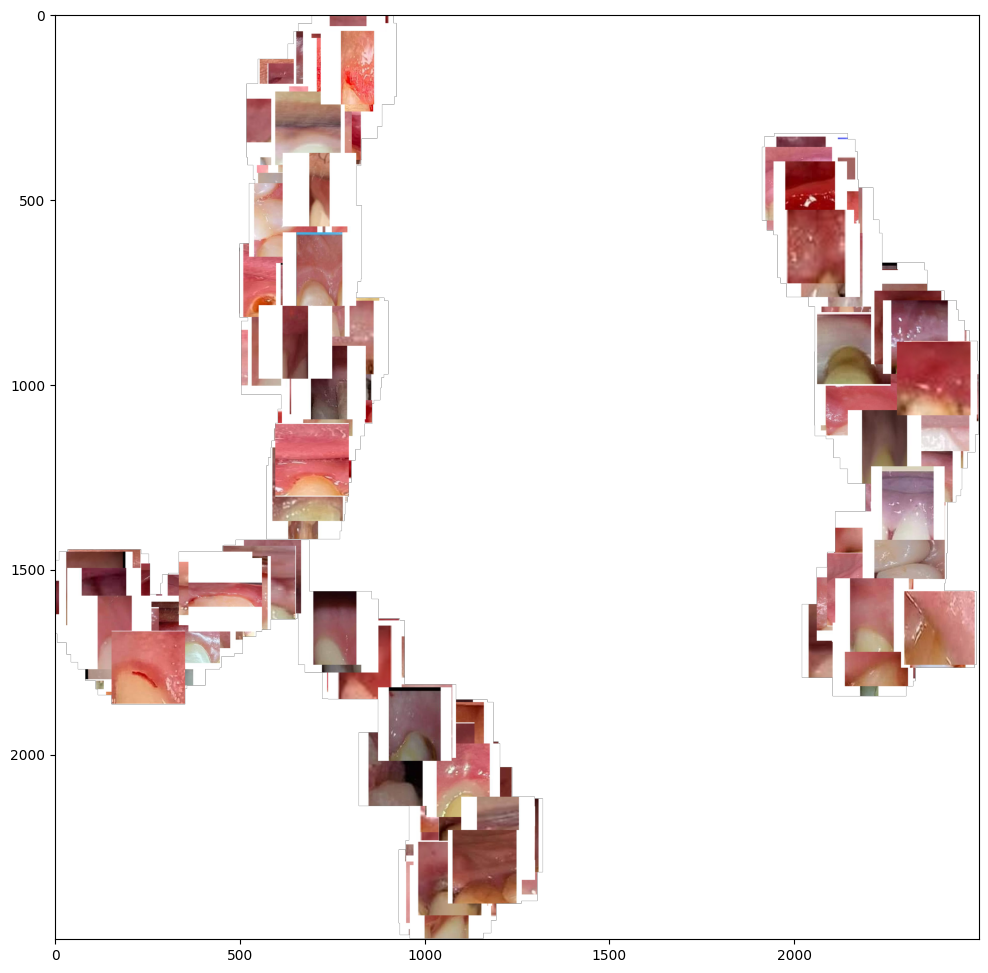

In [ ]:
width = 2500
height = 2500
max_dim = 200
save_to_png = True
te_filepath = test_df['Filepath'].tolist()

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(te_filepath, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))
plt.figure(figsize = (16,12))
plt.imshow(full_image)

## Saving Model

In [ ]:
conv_model.save_weights(f'{Save_model_path}/gingivititis_classification_weight_final.hdf5')